In [ ]:
import pandas as pd

In [ ]:
!pip install pyspark
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import  StringIndexer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 43 kB/s 
     |████████████████████████████████| 199 kB 63.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=33033befc3fb5056c24a604741b07d5cb2262b1a3881b1d5ff1e15cddd0039fd
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

In [ ]:
# Read data from the vehicle_stolen_dataset.csv
df = pd.read_csv("kredit.csv")
df.head()

,OCCUPATION,SALARY,INSTALLMENT,TENOR,USIA,MERK,STATUS
0,O3,1790400,440000,35,46,KAWASAKI,LUNAS
1,O3,1650000,506000,35,51,HONDA,TARIKAN
2,O3,1942000,435000,36,44,HONDA,LUNAS
3,O2,1104000,364000,36,32,HONDA,LUNAS
4,O2,773452,175000,12,31,HONDA,LUNAS


In [ ]:
spark = SparkSession.builder.master("local[*]").getOrCreate() #Sets the Spark master URL to run locally.

In [ ]:
df = spark.createDataFrame(df)  #Create DataFrame
df.show(5)

+----------+-------+-----------+-----+----+--------+-------+
|OCCUPATION| SALARY|INSTALLMENT|TENOR|USIA|    MERK| STATUS|
+----------+-------+-----------+-----+----+--------+-------+
|        O3|1790400|     440000|   35|  46|KAWASAKI|  LUNAS|
|        O3|1650000|     506000|   35|  51|   HONDA|TARIKAN|
|        O3|1942000|     435000|   36|  44|   HONDA|  LUNAS|
|        O2|1104000|     364000|   36|  32|   HONDA|  LUNAS|
|        O2| 773452|     175000|   12|  31|   HONDA|  LUNAS|
+----------+-------+-----------+-----+----+--------+-------+
only showing top 5 rows



In [ ]:
indexers = [StringIndexer(inputCol="OCCUPATION", outputCol = "OCCUPATION_INDEX"), 
           StringIndexer(inputCol="MERK", outputCol = "MERK_INDEX"), 
           StringIndexer(inputCol="STATUS", outputCol = "label"),
            ]

In [ ]:
pipeline = Pipeline(stages=indexers)
indexed_df = pipeline.fit(df).transform(df)

In [ ]:
indexed_df.show(5,False)

+----------+-------+-----------+-----+----+--------+-------+----------------+----------+-----+
|OCCUPATION|SALARY |INSTALLMENT|TENOR|USIA|MERK    |STATUS |OCCUPATION_INDEX|MERK_INDEX|label|
+----------+-------+-----------+-----+----+--------+-------+----------------+----------+-----+
|O3        |1790400|440000     |35   |46  |KAWASAKI|LUNAS  |0.0             |1.0       |0.0  |
|O3        |1650000|506000     |35   |51  |HONDA   |TARIKAN|0.0             |2.0       |1.0  |
|O3        |1942000|435000     |36   |44  |HONDA   |LUNAS  |0.0             |2.0       |0.0  |
|O2        |1104000|364000     |36   |32  |HONDA   |LUNAS  |1.0             |2.0       |0.0  |
|O2        |773452 |175000     |12   |31  |HONDA   |LUNAS  |1.0             |2.0       |0.0  |
+----------+-------+-----------+-----+----+--------+-------+----------------+----------+-----+
only showing top 5 rows



In [ ]:
vectorAssembler = VectorAssembler(inputCols = ["OCCUPATION_INDEX", "MERK_INDEX"],outputCol = "features")
vindexed_df = vectorAssembler.transform(indexed_df)

In [ ]:
vindexed_df.show(5, False)

+----------+-------+-----------+-----+----+--------+-------+----------------+----------+-----+---------+
|OCCUPATION|SALARY |INSTALLMENT|TENOR|USIA|MERK    |STATUS |OCCUPATION_INDEX|MERK_INDEX|label|features |
+----------+-------+-----------+-----+----+--------+-------+----------------+----------+-----+---------+
|O3        |1790400|440000     |35   |46  |KAWASAKI|LUNAS  |0.0             |1.0       |0.0  |[0.0,1.0]|
|O3        |1650000|506000     |35   |51  |HONDA   |TARIKAN|0.0             |2.0       |1.0  |[0.0,2.0]|
|O3        |1942000|435000     |36   |44  |HONDA   |LUNAS  |0.0             |2.0       |0.0  |[0.0,2.0]|
|O2        |1104000|364000     |36   |32  |HONDA   |LUNAS  |1.0             |2.0       |0.0  |[1.0,2.0]|
|O2        |773452 |175000     |12   |31  |HONDA   |LUNAS  |1.0             |2.0       |0.0  |[1.0,2.0]|
+----------+-------+-----------+-----+----+--------+-------+----------------+----------+-----+---------+
only showing top 5 rows



# Linear SVM Classification


In [ ]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
splits = vindexed_df.randomSplit([0.6,0.4], 42)    # optional value 42 is seed for sampling
train_df = splits[0]
test_df = splits[1]
print(splits)
print(test_df)

[DataFrame[OCCUPATION: string, SALARY: bigint, INSTALLMENT: bigint, TENOR: bigint, USIA: bigint, MERK: string, STATUS: string, OCCUPATION_INDEX: double, MERK_INDEX: double, label: double, features: vector], DataFrame[OCCUPATION: string, SALARY: bigint, INSTALLMENT: bigint, TENOR: bigint, USIA: bigint, MERK: string, STATUS: string, OCCUPATION_INDEX: double, MERK_INDEX: double, label: double, features: vector]]
DataFrame[OCCUPATION: string, SALARY: bigint, INSTALLMENT: bigint, TENOR: bigint, USIA: bigint, MERK: string, STATUS: string, OCCUPATION_INDEX: double, MERK_INDEX: double, label: double, features: vector]


In [ ]:
# Apply the Linear SVM classifier
lsvc = LinearSVC(maxIter=10, regParam=0.1)

In [ ]:
# train the model
lsvcModel = lsvc.fit(train_df)

In [ ]:
predictions_df = lsvcModel.transform(test_df)
predictions_df.show(5)

+----------+-------+-----------+-----+----+--------+-------+----------------+----------+-----+---------+--------------------+----------+
|OCCUPATION| SALARY|INSTALLMENT|TENOR|USIA|    MERK| STATUS|OCCUPATION_INDEX|MERK_INDEX|label| features|       rawPrediction|prediction|
+----------+-------+-----------+-----+----+--------+-------+----------------+----------+-----+---------+--------------------+----------+
|        O1| 774700|     459000|   35|  41|KAWASAKI|  LUNAS|             2.0|       1.0|  0.0|[2.0,1.0]|[1.16201759409656...|       0.0|
|        O1| 840400|     502000|   23|  58|  SUZUKI|TARIKAN|             2.0|       0.0|  1.0|[2.0,0.0]|[1.16201759409656...|       0.0|
|        O1| 970000|     496000|   35|  53|  SUZUKI|  LUNAS|             2.0|       0.0|  0.0|[2.0,0.0]|[1.16201759409656...|       0.0|
|        O1| 997400|     346000|   36|  61|  SUZUKI|  LUNAS|             2.0|       0.0|  0.0|[2.0,0.0]|[1.16201759409656...|       0.0|
|        O1|1030700|     300000|   36|  4

Confusion Matrix:


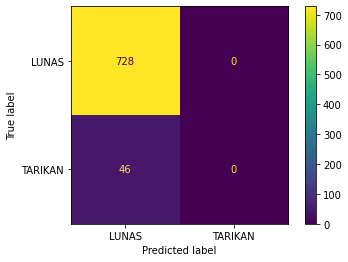

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = predictions_df.select("prediction").collect()
y_ori = predictions_df.select("label").collect()

cm = confusion_matrix(y_ori, y_pred)
print("Confusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["LUNAS", "TARIKAN"])
disp.plot()

In [ ]:
# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lsvmaccuracy = evaluator.evaluate(predictions_df)
print("Accuracy = " + str(lsvmaccuracy))

Accuracy = 0.9405684754521964
